## Handwriting: OCR

Dataset Source: https://www.kaggle.com/datasets/ssarkar445/handwriting-recognitionocr

##### Install Necessary Libraries

In [1]:
%pip install torch torchvision transformers evaluate jiwer

Note: you may need to restart the kernel to use updated packages.


##### Import Necessary Libraries

In [2]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import tqdm

import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset

import transformers
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, default_data_collator

import evaluate

!git lfs install

Git LFS initialized.


##### Display Versions of Relevant Software & Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.7 
        Pandas: 1.4.4
  Transformers: 4.26.0
         Torch: 1.12.1


### Ingest & (Start to) Preprocess Training Dataset

In [4]:
training_parent_dir = "/Users/leedunn/Desktop/Projects_to_Train/OCR/data/train"

train_df = pd.read_csv(os.path.join(training_parent_dir, "_annotations.csv"))

train_df = train_df.drop(columns=['Unnamed: 0'])
train_df = train_df.rename(columns={"FILENAME" : "file_name", "IDENTITY" : "text"})
train_df = train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  20000 non-null  object
 1   text       20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


#### Visualize: Histogram of Training Text Lengths

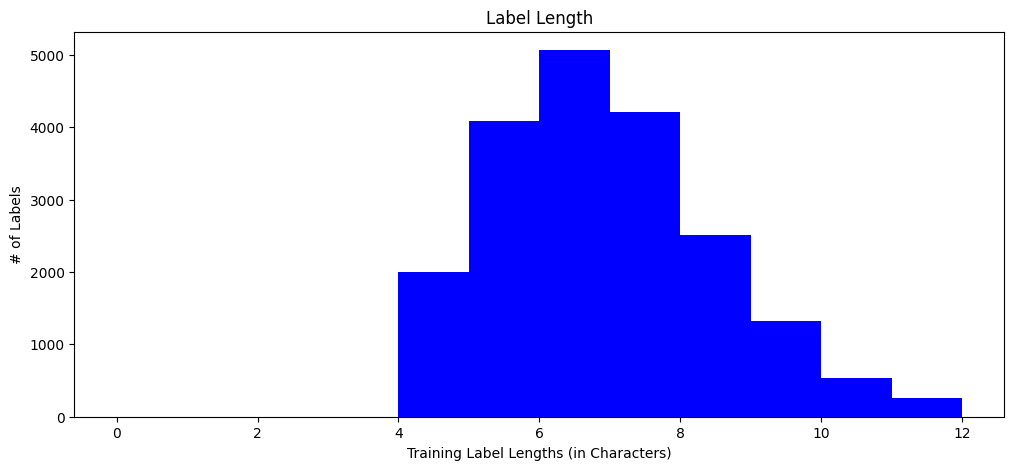

In [5]:
train_df['label_len'] = train_df['text'].str.len()

max_length_value = 11
train_df.hist("label_len", 
             grid=False, 
             color="Blue", 
             figsize=(12,5), 
             bins=max_length_value + 1, 
             range=(0, max_length_value + 1)
             )

plt.suptitle('')
plt.xlabel('Training Label Lengths (in Characters)')
plt.ylabel('# of Labels')
plt.title('Label Length')
plt.show()

train_df = train_df.drop(columns=['label_len'])

### Ingest & (Start to) Preprocess Evaluation Dataset

In [6]:
eval_parent_dir = "/Users/leedunn/Desktop/Projects_to_Train/OCR/data/eval"

eval_df = pd.read_csv(os.path.join(eval_parent_dir, "_annotations.csv"))

eval_df = eval_df.drop(columns=['Unnamed: 0'])
eval_df = eval_df.rename(columns={"FILENAME" : "file_name", "IDENTITY" : "text"})
eval_df = eval_df.dropna()
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5000 non-null   object
 1   text       5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


#### Visualize: Histogram of Evaluation Text Lengths

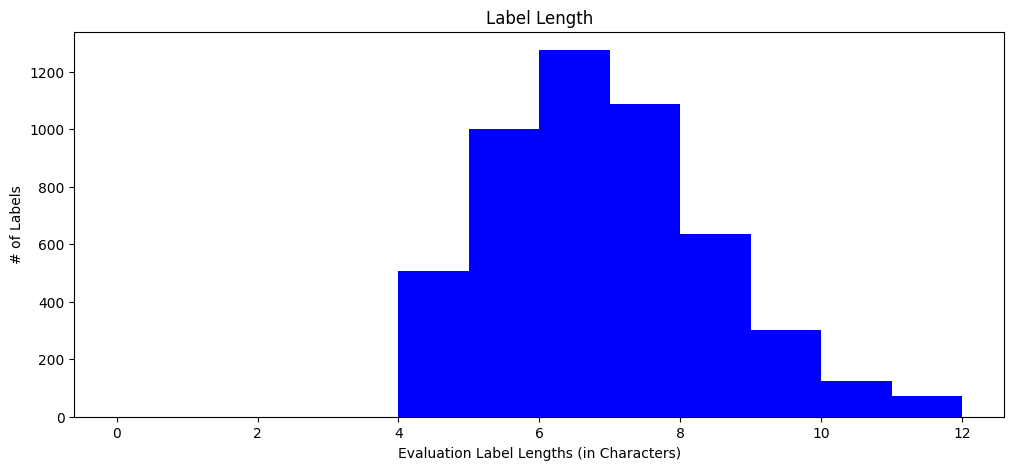

In [7]:
eval_df['label_len'] = eval_df['text'].str.len()

max_length_value = 11
eval_df.hist("label_len", 
             grid=False, 
             color="Blue", 
             figsize=(12,5), 
             bins=max_length_value + 1, 
             range=(0, max_length_value + 1)
             )

plt.suptitle('')
plt.xlabel('Evaluation Label Lengths (in Characters)')
plt.ylabel('# of Labels')
plt.title('Label Length')
plt.show()

eval_df = eval_df.drop(columns=['label_len'])

##### Create Dataset Class

In [8]:
class Handwriting_Recognition_OCR_Dataset(Dataset):
    
    def __init__(self, root_dir, df, processor, max_target_length=14):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length
                                          ).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id 
                  else -100 for label in labels]
        
        encoding = {"pixel_values" : pixel_values.squeeze(), "labels" : torch.tensor(labels)}
        return encoding

##### Basic Values/Constants

In [9]:
MODEL_CKPT = "microsoft/trocr-base-handwritten"
MODEL_NAME =  MODEL_CKPT.split("/")[-1] + "-OCR-handwriting_recognition_v2"

NUM_OF_EPOCHS = 3
BATCH_SIZE = 8

##### Instantiate Processor, Create Training, & Testing Dataset Instances

In [10]:
image_processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)

train_ds = Handwriting_Recognition_OCR_Dataset(root_dir=training_parent_dir + "/",
                             df=train_df,
                             processor=image_processor)

eval_ds = Handwriting_Recognition_OCR_Dataset(root_dir=eval_parent_dir + "/",
                             df=eval_df,
                             processor=image_processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


##### Print Length of Training & Testing Datasets

In [11]:
print(f"The training dataset has {len(train_ds)} samples in it.")
print(f"The testing dataset has {len(eval_ds)} samples in it.")

The training dataset has 20000 samples in it.
The testing dataset has 5000 samples in it.


##### Example of Input Data Shapes

In [12]:
encoding = train_ds[10]

for k,v in encoding.items():
    print(k, " : ", v.shape)

pixel_values  :  torch.Size([3, 384, 384])
labels  :  torch.Size([14])


##### Show Example

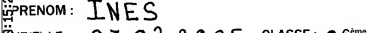

In [13]:
image = Image.open(train_ds.root_dir + train_df['file_name'][10]).convert("RGB")

image

##### Show Label for Above Example

In [14]:
labels = encoding['labels']
labels[labels == -100] = image_processor.tokenizer.pad_token_id
label_str = image_processor.decode(labels, skip_special_tokens=True)
print(label_str)

INES


#### Instantiate Model

In [15]:
model = VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Model Configuration Modifications

In [16]:
model.config.decoder_start_token_id = image_processor.tokenizer.cls_token_id
model.config.pad_token_id = image_processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = image_processor.tokenizer.sep_token_id
model.config.max_length = max_length_value
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 0.0
model.config.num_beams = 8

print(model.config.max_length)

11


##### Define Metrics Evaluation

In [17]:
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions
    
    pred_str = image_processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = image_processor.tokenizer.pad_token_id
    label_str = image_processor.batch_decode(label_ids, skip_special_tokens=True)
    
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    return {"cer" : cer}

##### Define Training Arguments

In [18]:
args = Seq2SeqTrainingArguments(
    output_dir = MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    logging_first_step=True,
    log_level="error",
    disable_tqdm=False,
    logging_strategy="steps",
    logging_steps=100,
    hub_private_repo=True,
    push_to_hub=True
)

##### Define Trainer

In [19]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=image_processor.feature_extractor,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=default_data_collator
)

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Cloning https://huggingface.co/DunnBC22/trocr-base-handwritten-OCR-handwriting_recognition_v2 into local empty directory.


##### Fit/Train Model

In [20]:
train_results = trainer.train()

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/7500 [00:00<?, ?it/s]

{'loss': 11.1109, 'learning_rate': 4.9993333333333335e-05, 'epoch': 0.0}
{'loss': 1.4302, 'learning_rate': 4.933333333333334e-05, 'epoch': 0.04}
{'loss': 1.2735, 'learning_rate': 4.866666666666667e-05, 'epoch': 0.08}
{'loss': 0.988, 'learning_rate': 4.8e-05, 'epoch': 0.12}
{'loss': 0.9493, 'learning_rate': 4.7333333333333336e-05, 'epoch': 0.16}
{'loss': 0.8475, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.2}
{'loss': 0.914, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.24}
{'loss': 0.7928, 'learning_rate': 4.5333333333333335e-05, 'epoch': 0.28}
{'loss': 0.7202, 'learning_rate': 4.466666666666667e-05, 'epoch': 0.32}
{'loss': 0.7261, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.36}
{'loss': 0.6637, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}
{'loss': 0.7632, 'learning_rate': 4.266666666666667e-05, 'epoch': 0.44}
{'loss': 0.6328, 'learning_rate': 4.2e-05, 'epoch': 0.48}
{'loss': 0.6182, 'learning_rate': 4.133333333333333e-05, 'epoch': 0.52}
{'loss': 0.6197, 'l

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.43323373794555664, 'eval_cer': 0.06794180866639668, 'eval_runtime': 125517.0167, 'eval_samples_per_second': 0.04, 'eval_steps_per_second': 0.005, 'epoch': 1.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'loss': 0.3212, 'learning_rate': 3.266666666666667e-05, 'epoch': 1.04}
{'loss': 0.3534, 'learning_rate': 3.2000000000000005e-05, 'epoch': 1.08}
{'loss': 0.3682, 'learning_rate': 3.1333333333333334e-05, 'epoch': 1.12}
{'loss': 0.3708, 'learning_rate': 3.066666666666667e-05, 'epoch': 1.16}
{'loss': 0.3439, 'learning_rate': 3e-05, 'epoch': 1.2}
{'loss': 0.3691, 'learning_rate': 2.9333333333333336e-05, 'epoch': 1.24}
{'loss': 0.345, 'learning_rate': 2.8666666666666668e-05, 'epoch': 1.28}
{'loss': 0.3942, 'learning_rate': 2.8000000000000003e-05, 'epoch': 1.32}
{'loss': 0.3336, 'learning_rate': 2.733333333333333e-05, 'epoch': 1.36}
{'loss': 0.2959, 'learning_rate': 2.6666666666666667e-05, 'epoch': 1.4}
{'loss': 0.3582, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.44}
{'loss': 0.3304, 'learning_rate': 2.5333333333333337e-05, 'epoch': 1.48}
{'loss': 0.325, 'learning_rate': 2.466666666666667e-05, 'epoch': 1.52}
{'loss': 0.2756, 'learning_rate': 2.4e-05, 'epoch': 1.56}
{'loss': 0.2768, '

  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.27674123644828796, 'eval_cer': 0.04834740350767889, 'eval_runtime': 122460.8505, 'eval_samples_per_second': 0.041, 'eval_steps_per_second': 0.005, 'epoch': 2.0}
{'loss': 0.1654, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.04}
{'loss': 0.1251, 'learning_rate': 1.5333333333333334e-05, 'epoch': 2.08}
{'loss': 0.1448, 'learning_rate': 1.4666666666666668e-05, 'epoch': 2.12}
{'loss': 0.1635, 'learning_rate': 1.4000000000000001e-05, 'epoch': 2.16}
{'loss': 0.1382, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.2}
{'loss': 0.1436, 'learning_rate': 1.2666666666666668e-05, 'epoch': 2.24}
{'loss': 0.143, 'learning_rate': 1.2e-05, 'epoch': 2.28}
{'loss': 0.1311, 'learning_rate': 1.1333333333333334e-05, 'epoch': 2.32}
{'loss': 0.1339, 'learning_rate': 1.0666666666666667e-05, 'epoch': 2.36}
{'loss': 0.1394, 'learning_rate': 1e-05, 'epoch': 2.4}
{'loss': 0.1251, 'learning_rate': 9.333333333333334e-06, 'epoch': 2.44}
{'loss': 0.1333, 'learning_rate': 8.666666666666668e-06,

  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.2470209002494812, 'eval_cer': 0.036042490888134326, 'eval_runtime': 124535.0211, 'eval_samples_per_second': 0.04, 'eval_steps_per_second': 0.005, 'epoch': 3.0}
{'train_runtime': 1284327.9471, 'train_samples_per_second': 0.047, 'train_steps_per_second': 0.006, 'train_loss': 0.3862592127482096, 'epoch': 3.0}


##### Save Model & Training Metrics

In [26]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

To https://huggingface.co/DunnBC22/trocr-base-handwritten-OCR-handwriting_recognition_v2
   b152177..068de93  main -> main



***** train metrics *****
  epoch                    =                  3.0
  train_loss               =               0.3863
  train_runtime            = 14 days, 20:45:27.94
  train_samples_per_second =                0.047
  train_steps_per_second   =                0.006


##### Push Model to Hub (My Profile!!!)

In [24]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-to-text",
    "tags" : ["image-to-text"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Several commits (3) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/1.24G [00:00<?, ?B/s]

Upload file runs/.DS_Store:   0%|          | 1.00/6.00k [00:00<?, ?B/s]

Upload file runs/Apr16_19-13-37_Lees-Air/events.out.tfevents.1681690423.Lees-Air.32246.0:   0%|          | 1.0…

Upload file .DS_Store:   0%|          | 1.00/6.00k [00:00<?, ?B/s]

To https://huggingface.co/DunnBC22/trocr-base-handwritten-OCR-handwriting_recognition_v2
   91f19c1..56d448f  main -> main



### Notes & Other Takeaways From This Project
****
- Unfortunately, I had to reduce the sample size for this project to make it feasible to run. If I had kept it as it was, it would have taken about two months per epoch. Yikes! 
- A Character Error Rate (CER) of 0.0360 is pretty good for the limited training sample size.
****

### Citations

##### For Transformer Checkpoint
- @misc{li2021trocr,
      title={TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models}, 
      author={Minghao Li and Tengchao Lv and Lei Cui and Yijuan Lu and Dinei Florencio and Cha Zhang and Zhoujun Li and Furu Wei},
      year={2021},
      eprint={2109.10282},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}

##### For CER Metric
- @inproceedings{morris2004,
author = {Morris, Andrew and Maier, Viktoria and Green, Phil},
year = {2004},
month = {01},
pages = {},
title = {From WER and RIL to MER and WIL: improved evaluation measures for connected speech recognition.}
}